In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr

## <center> - - - - - <br> GWAS catalog <br> - - - - - </center>
<br> The dataset from "www.ebi.ac.uk/gwas/" containing over 700,000 SNPs association with a phenotypic trait.
<br> <br> In the section we:
- Retaining genome-wide significant SNVs (p-value lower than 5 * 10<sup>-8</sup>)
- Detecting how many of such SNVs are unique (are encountered only once in the dataset)
- Data engineering before merging it with microprotein dataset

In [6]:
## The genome wide significant p-value threshold: p = 5 * 10-8

gwas_raw = pd.read_csv('./gwas_cat_10000.tsv', sep='\t')

pd.set_option('display.max_columns', None)
# gwas_raw.head(5)
# print(gwas_raw.columns)
columns_to_leave_gwas = ["REGION", "CHR_ID", "CHR_POS", "STRONGEST SNP-RISK ALLELE", "P-VALUE", 
                         "PVALUE_MLOG", "DISEASE/TRAIT", "MAPPED_GENE", "PUBMEDID", "CONTEXT", "INTERGENIC",
                         "RISK ALLELE FREQUENCY", "OR or BETA", "95% CI (TEXT)", "MAPPED_TRAIT"]

gwas_df = gwas_raw[columns_to_leave_gwas]
gwas_df.head()

## how many studies are combined
# gwas_raw["PUBMEDID"].drop_duplicates().shape

/var/folders/fw/ykhh2hsx0jj595tmywd799_00000gn/T/ipykernel_99647/4128113988.py:3: DtypeWarning: Columns (9,11,12,13,23,26,29,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  gwas_raw = pd.read_csv('./gwas_cat_10000.tsv', sep='\t')


,REGION,CHR_ID,CHR_POS,STRONGEST SNP-RISK ALLELE,P-VALUE,PVALUE_MLOG,DISEASE/TRAIT,MAPPED_GENE,PUBMEDID,CONTEXT,INTERGENIC,RISK ALLELE FREQUENCY,OR or BETA,95% CI (TEXT),MAPPED_TRAIT
0,7q31.31,7,117874786,rs6965740-T,1.000000e-08,8.000000,Smoking initiation,CTTNBP2 - LSM8,30617275,intergenic_variant,1.0,0.31,0.0126,[0.0067-0.0185] unit decrease (replication),smoking initiation
1,8p21.1,8,27560912,rs11776293-T,2.000000e-12,11.698970,Smoking initiation,GULOP,30617275,intergenic_variant,0.0,0.12,0.0200,[0.014-0.026] unit decrease (replication),smoking initiation
2,8q12.1,8,58904509,rs1562612-G,1.000000e-09,9.000000,Smoking initiation,TOX,30617275,intron_variant,0.0,0.35,0.0112,[0.0053-0.0171] unit decrease (replication),smoking initiation
3,8q21.3,8,92171837,rs3857914-C,2.000000e-09,8.698970,Smoking initiation,RUNX1T1 - FLJ46284,30617275,intergenic_variant,1.0,0.19,0.0157,[0.0098-0.0216] unit increase (replication),smoking initiation
4,15q21.1,15,47351598,rs557899-A,3.000000e-13,12.522879,Smoking initiation,SEMA6D,30617275,intron_variant,0.0,0.26,0.0157,[0.0098-0.0216] unit increase (replication),smoking initiation


In [67]:
## checking whether all examples pass the p-value threshold

print("Original GWAS Catalog shape:",gwas_df.shape)
gwas_significant_df = gwas_df.copy()


#### STANDARDIZING FORMATTING

## keeping valid CHR_ID formats (1-22, X, Y)
gwas_significant_df["CHR_ID"] = gwas_significant_df["CHR_ID"].astype(str).str.upper()
valid_chromosomes = [str(i) for i in range(1, 23)] + ['X', 'Y']
gwas_significant_df = gwas_significant_df[gwas_significant_df["CHR_ID"].isin(valid_chromosomes)]
print("After standardizing formatting (CHR_ID):",gwas_significant_df.shape)


## keeping valid CHR_POS formatting (single value)
## p.s. after dropping invalid CHR_ID, CHR_POS in the remaining rows were alright

def single_position(chr_pos):
    try:
        f = float(chr_pos)
        return f.is_integer()
    except:
        return False

single_pos_mask = gwas_significant_df["CHR_POS"].apply(single_position)

gwas_significant_df = gwas_significant_df[single_pos_mask]
gwas_significant_df["CHR_POS"] = gwas_significant_df["CHR_POS"].astype(float).astype(int)
print("After standardizing formatting (CHR_POS):",gwas_significant_df.shape)

## Saving 632,656 standardized SNVs for generating manhattan plot
following_manhattan = gwas_significant_df.copy()
following_manhattan["SNP_RS"] = following_manhattan["STRONGEST SNP-RISK ALLELE"].str.split("-").str[0]
following_manhattan = following_manhattan.rename(columns={
    "CHR_ID": "CHROM",
    "CHR_POS": "POS",
    "P-VALUE": "P"
})

selected_columns = ["SNP_RS", "CHROM", "POS", "P"]
man_filtered = following_manhattan[selected_columns]
## changing single row, since there is a blank present (only in the whole set)
man_filtered.loc[man_filtered["SNP_RS"] == "rs6194 5053", "SNP_RS"] = "rs61945053"
# print(man_filtered.iloc[256699])
man_filtered.to_csv("../manhattan_plot/initial_632656.txt", index=False, sep="\t")


#### FILTERING BASED ON P-VALUE

## how many unique SNV (however, the dataset is not changed)
gwas_significant_df["CHROM"] = (gwas_significant_df["CHR_ID"].astype(str) + "_" + gwas_significant_df["CHR_POS"].astype(str))

gwas_significant_df = gwas_significant_df[gwas_significant_df["P-VALUE"] < 5e-8]
print("After filtiring by p-value:",gwas_significant_df.shape)

print(f"Unique chromosomal positions: {len(np.unique(gwas_significant_df['CHROM']))}/{gwas_significant_df.shape[0]}")

# gwas_significant_df.head()

Original GWAS Catalog shape: (786898, 15)
After standardizing formatting (CHR_ID): (632656, 15)
After standardizing formatting (CHR_POS): (632656, 15)
After filtiring by p-value: (508949, 16)
Unique chromosomal positions: 220293/508949



 ### <center> <br> ### END OF THE SECTION ### <br> </center>


## <center> - - - - - <br> Dark genome <br> - - - - - </center>

<br> The dataset from the main article containing info about 3,085/7,264 unique micropetides (that are supported by at least two Ribo-seq studies). <br>
Obtained from https://doi.org/10.1038/s41587-022-01369-0



In the section we:
- We prepare the data for upcoming merging with GWAS Catalog
- Summary of gene distribution among chromosomes

In [52]:
## "phase.txt" is taken from the "phase1_microproteins.xlsx" sheet "S2. PHASE I Ribo-seq ORFs"  

phase = pd.read_csv("phase.txt", sep = '\t')

# phase.head()
# print(phase.isna().sum())

## divide rows that have two starts and ends onto two separated rows
phase_extended = phase.copy()

phase_extended["old_starts"] = phase["starts"]
phase_extended["old_ends"] = phase["ends"]
phase_extended["starts"] = phase["starts"].str.split(";").str[0]  # keep first start
phase_extended["ends"] = phase["ends"].str.split(";").str[-1]  # keep last end

## excluding those ORFs that are equal to or longer than 300 nucleotides (not the scope of the study)
print("Number of microproteins found in at least 2 articles:", phase_extended.shape[0])
phase_extended = phase_extended[phase_extended["orf_length"] < 300]
print(f"Number of those that < 300 (ORF length): {phase_extended.shape[0]} ({3085-phase_extended.shape[0]} were excluded)")


## divide rows that have X starts and ends onto X separated rows -- p.s. first approach (not the best)
# phase_extended["starts"] = phase["starts"].str.split(";")
# phase_extended["ends"] = phase["ends"].str.split(";")
# phase_extended = phase_extended.explode(["starts", "ends"], ignore_index=True) # create separate rows
# phase_extended["starts"] = phase_extended["starts"].astype(int)
# phase_extended["ends"] = phase_extended["ends"].astype(int)

# print(f"Before splitting: {phase.shape[0]}")
# print(f"After splitting: {phase_extended.shape[0]}")

## VALIDATE CORRECTNESS OF CORRELATION BETWEEN ORF AND PROTEIN LENGTHES -- p.s. all good
# phase_extended["amino_to_nt"] = phase_extended["orf_sequence"].apply(len) * 3 / phase_extended["orf_length"]
# print(phase_extended["amino_to_nt"].value_counts())

Number of microproteins found in at least 2 articles: 3085
Number of those that < 300 (ORF length): 2952 (133 were excluded)


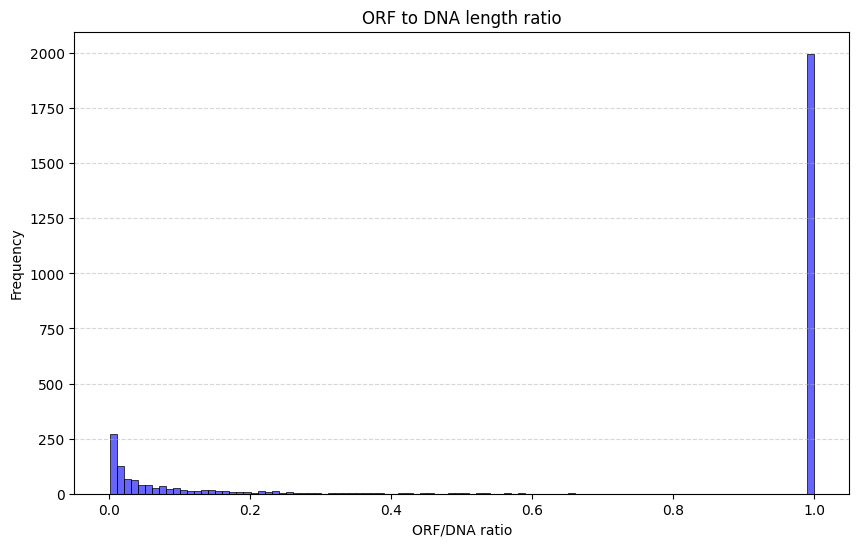

In [51]:
## compare the ORF length in the table with DNA lenght (start->end)
phase_extended["gene_length"] = phase_extended["ends"].astype(int) - phase_extended["starts"].astype(int) + 1
phase_extended["length_check"] = phase_extended["orf_length"] / phase_extended["gene_length"]

# microprotein_lengths = phase_extended["length_check"].value_counts()
# print(microprotein_lengths[microprotein_lengths > 1]) 
## 1997 microproteins without introns (length_check = 1)

## bin plot
bin_size = 0.01  
bins = np.arange(phase_extended["length_check"].min(), phase_extended["length_check"].max()+ bin_size, bin_size)

plt.figure(figsize=(10, 6))
sns.histplot(phase_extended["length_check"], bins=bins, kde=False, color="blue", alpha=0.6, edgecolor="black")
plt.xlabel("ORF/DNA ratio")
plt.ylabel("Frequency")
plt.title("ORF to DNA length ratio")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


In [16]:
columns_to_leave_phase = ["orf_name", "chrm", "starts", "ends", "old_starts", "old_ends", "orf_biotype", 
                          "gene_biotype", "orf_sequence", "orf_length", "gene_length", "length_check", "gene_name", "Riboseq_evidence"]

phase_df = phase_extended.copy()
phase_df = phase_df[columns_to_leave_phase]

## check whether all chromosome IDs are present 
# print(f"Chromosomes present: {len(phase_df['chrm'].value_counts())}/24")

phase_df["chrom_id"] = (phase_df["chrm"].astype(str) + "_" + phase_df["starts"].astype(str))

# phase_df.info()
# phase_df.head()

In [17]:
## convert all chromosome IDs to integers
def chromosome_sort(chrom):
    if chrom.isdigit():  
        return int(chrom)
    elif chrom == "X":
        return 23
    elif chrom == "Y":
        pass


### creating summary for each chromosome. summary includes:
### - number of ORFs per chromosome (non-coding, coding)
### - average length of ORFs in a chromosome
### - average length of gene (ORF + introns) in a chromosome

non_coding_genes = phase_df[phase_df["gene_biotype"] == "non-coding"]
non_coding_summary = non_coding_genes.groupby("chrm")["chrom_id"].count().reset_index()
non_coding_summary = non_coding_summary.rename(columns={"chrom_id": "non_coding_count"})
# print(non_coding_summary)

coding_genes = phase_df[phase_df["gene_biotype"] == "protein_coding"]
coding_summary = coding_genes.groupby("chrm")["chrom_id"].count().reset_index()
coding_summary = coding_summary.rename(columns={"chrom_id": "coding_count"})
# print(coding_summary)


combined_summary = pd.merge(non_coding_summary, coding_summary, on="chrm", how="outer")
combined_summary["chrm"] = combined_summary["chrm"].astype(str)
combined_summary["non_coding_count"] = combined_summary["non_coding_count"].fillna(0).astype(int)
combined_summary = combined_summary[combined_summary["chrm"] != "Y"] # exclude Y chromosome
combined_summary["n_genes"] = combined_summary["non_coding_count"] + combined_summary["coding_count"]
combined_summary = combined_summary.sort_values(by="chrm", key=lambda x: x.map(chromosome_sort)).reset_index(drop=True)

avg_length_dna = phase_df.groupby("chrm")["gene_length"].mean().reset_index()
avg_length_dna = avg_length_dna.rename(columns={"gene_length": "avg_gene_length"})
combined_summary = pd.merge(combined_summary, avg_length_dna, on="chrm", how="left")

avg_length_orf = phase_df.groupby("chrm")["orf_length"].mean().reset_index()
avg_length_orf = avg_length_orf.rename(columns={"orf_length": "avg_orf_length"})
combined_summary = pd.merge(combined_summary, avg_length_orf, on="chrm", how="left")


combined_summary

,chrm,non_coding_count,coding_count,n_genes,avg_gene_length,avg_orf_length
0,1,45,244,289,4190.671280,115.733564
1,2,33,152,185,5546.600000,116.189189
2,3,22,163,185,4916.654054,120.778378
3,4,20,105,125,5858.576000,115.248000
4,5,32,109,141,4462.390071,115.638298
5,6,24,112,136,5784.338235,111.463235
6,7,36,125,161,5279.242236,121.602484
7,8,22,100,122,7178.532787,115.377049
8,9,22,94,116,3453.724138,118.551724
9,10,26,101,127,4970.692913,110.362205


### <center> <br> ### END OF THE SECTION ### <br> </center>

## <center> - - - - - <br> MERGING <br> - - - - - </center>
In the section we are looking for the SNVs that are directly located within microprotein-encoding regions <br> <br>


#### 1. Filtering right SNPs
<br> Here we are overlaying two dataset gwas_significant_df and phase_df (based on chromosome IDs and span of regions)

In [20]:
gwas_unique_df = gwas_significant_df.copy()

# gwas_unique_df = gwas_significant_df.drop_duplicates(subset=["CHROM"])
# gwas_unique_df = gwas_unique_df.dropna(subset =["CHR_ID"])
# gwas_unique_df.shape

# phase_df["chrm"] = phase_df["chrm"].replace({"X" : "23", "Y" : "24"})
# phase_df.chrm.value_counts()

In [55]:
phase_temp = phase_df.copy()
gwas_temp = gwas_unique_df.copy()



## gwas as pyranges object

# gwas_temp = gwas_temp.rename(columns={"CHR_ID": "Chromosome"})
# gwas_temp["CHR_POS"] = gwas_temp["CHR_POS"].astype(int)
gwas_temp["End"] = gwas_temp["CHR_POS"]  # pyranges needs a start and end
gwas_temp["Start"] = gwas_temp["CHR_POS"]

gwas_ranges = pr.PyRanges(
    gwas_temp.rename(columns={"CHR_ID": "Chromosome"})
    [["Chromosome", "Start", "End"] + [col for col in gwas_temp.columns if col not in ["CHR_ID", "CHR_POS", "Start", "End"]]]
)

## microprotein data as pyranges object

# phase_temp = phase_temp.rename(columns={"chrm": "Chromosome", "starts": "Start", "ends": "End"})
# phase_temp["chrm"] = phase_df["chrm"].astype(str)
# phase_temp["starts"] = phase_temp["starts"].astype(int)
# phase_temp["ends"] = phase_temp["ends"].astype(int)

phase_ranges = pr.PyRanges(
    phase_temp.rename(columns={"chrm": "Chromosome", "starts": "Start", "ends": "End"})
    [["Chromosome", "Start", "End"] + [col for col in phase_temp.columns if col not in ["chrm", "starts", "ends"]]]
)

# Overlapping (only keeps rows where SNV is within microprotein region)
result = gwas_ranges.join(phase_ranges)
# converting to pandas dataframe
acceptable_snp = result.df

acceptable_snp = acceptable_snp.rename(columns = {"Chromosome": "CHR_ID", "Start": "CHR_POS", "Start_b":"starts", "End_b":"ends"})
acceptable_snp = acceptable_snp.drop(columns = ["End"])

#### This approach worked, but it is very computationally heavy
## merging so the dataset contains all possible instances when microprotein and SNV chromosome ID mathes
# merged = gwas_temp.merge(phase_temp, left_on="CHR_ID", right_on="chrm", how="inner")
# ## keeping only those SNV that are directly located in the microprotein-encoding region
# acceptable_snp = merged[(merged["CHR_POS"] >= merged["starts"]) & (merged["CHR_POS"] <= merged["ends"])]

# displying results
print(f"Total SNPs in GWAS dataset: {len(gwas_temp)}")
print(f"Total SNPs inside regions: {len(acceptable_snp)}")


## saving SNVs overlapping with microprotein-encoding regions, used for manhattan plot
# overlaying_SNV = acceptable_snp.copy()
# overlaying_SNV["SNP_RS"] = overlaying_SNV["STRONGEST SNP-RISK ALLELE"].str.split("-").str[0]
# overlaying_SNV = overlaying_SNV.rename(columns={
#     "CHR_ID": "CHROM",
#     "CHR_POS": "POS",
#     "P-VALUE": "P"
# })

# selected_columns = ["SNP_RS", "CHROM", "POS", "P"]

# overlaying_filtered = overlaying_SNV[selected_columns]
# overlaying_filtered.to_csv("../manhattan_plot/overlaying_2838.txt", index=False, sep="\t") 


Total SNPs in GWAS dataset: 508949
Total SNPs inside regions: 2838


#### 2. Processing filtered SNPs
<br> We got 2838 SNVs of interest and in this section we decide: 
- what attributes we keep
- what ORF are the SNVs falling in
- number of SNVs per each chromosome

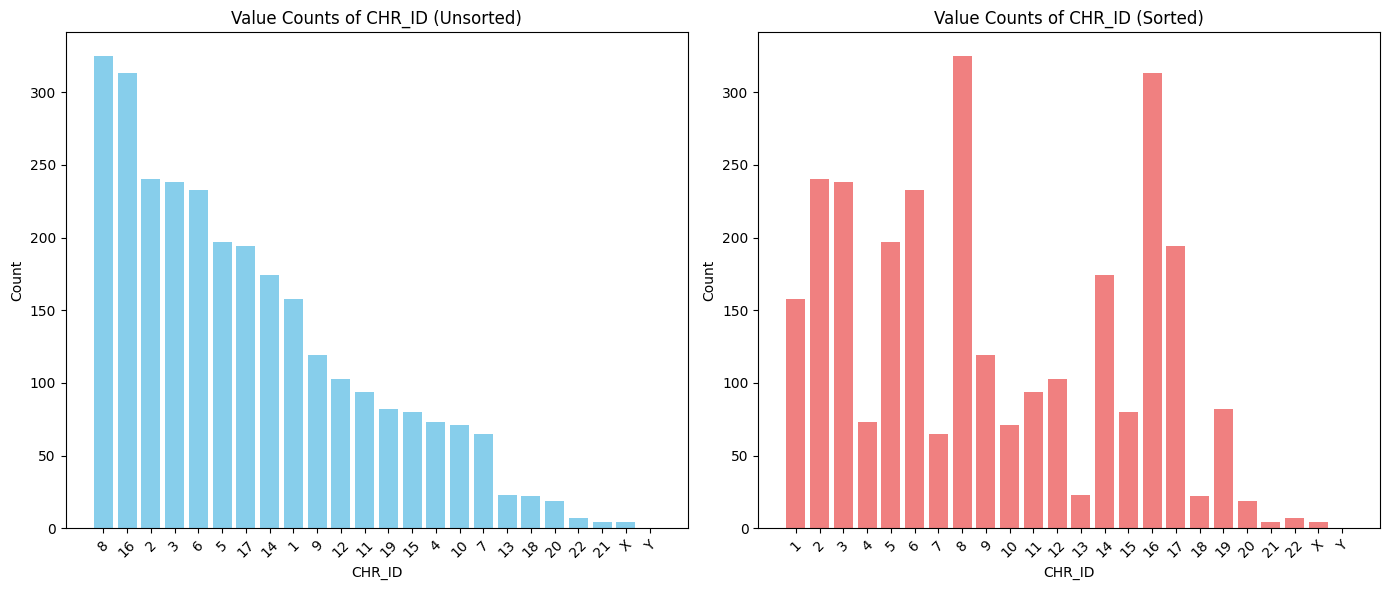

In [22]:
# print(phase_temp.shape)
# acceptable_snp.head()

snp_in_regions = acceptable_snp.copy()
# snp_in_regions.CHR_ID.value_counts()

snp_in_regions["SNP_RS"] = snp_in_regions["STRONGEST SNP-RISK ALLELE"].str.split("-").str[0]

### check how many SNVs per ORF
# snv_per_orf = snp_in_regions.orf_name.value_counts()
# print(snv_per_orf[snv_per_orf > 10])

value_counts = snp_in_regions["CHR_ID"].value_counts()

# 1-22 and X,Y in separate lists
numeric_chrs = []
non_numeric_chrs = []

for chr_id in value_counts.index:
    try:
        numeric_chrs.append((int(chr_id), chr_id))
    except ValueError:
        non_numeric_chrs.append(chr_id)

## sorting        
numeric_chrs.sort()
sorted_chr_labels = [label for _, label in numeric_chrs] + sorted(non_numeric_chrs)
sorted_value_counts = value_counts[sorted_chr_labels]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# first - unsorted
axes[0].bar(value_counts.index, value_counts.values, color="skyblue")
axes[0].set_xlabel("CHR_ID")
axes[0].set_ylabel("Count")
axes[0].set_title("Value Counts of CHR_ID (Unsorted)")
axes[0].tick_params(axis='x', rotation=45)

# second - sorted
axes[1].bar(sorted_value_counts.index, sorted_value_counts.values, color="lightcoral")
axes[1].set_xlabel("CHR_ID")
axes[1].set_ylabel("Count")
axes[1].set_title("Value Counts of CHR_ID (Sorted)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [24]:
## count how many starts and ends are there per ORF in the dataset
snp_in_regions["num_starts"] = snp_in_regions["old_starts"].astype(str).apply(lambda x: len(x.split(";")))
start_counts_per_gene = snp_in_regions["num_starts"].value_counts().sort_index()
print(start_counts_per_gene)

num_starts
1      65
2    2405
3     343
4      24
6       1
Name: count, dtype: int64


In [26]:
## for more comprehensive research this may be used to identify SNVs that fall in exonic part of a gene

def classify_snp_region(snp_pos, starts_list, ends_list):
    """Determine if SNP is in exon or intron based on start and end positions."""
    starts = [int(x) for x in starts_list]
    ends = [int(x) for x in ends_list]

    for i in range(len(starts)):
        # SNP is within exon
        if starts[i] <= snp_pos <= ends[i]:
            return "exon"
        # SNP is within intron (between exon end[i] and exon start[i+1])
        if i < len(starts) - 1 and ends[i] < snp_pos < starts[i + 1]:
            return "intron"

    # SNP is outside annotated regions
    return "unknown"

snp_in_regions_extended = snp_in_regions.copy()
snp_in_regions_extended["starts_list"] = snp_in_regions_extended["old_starts"].astype(str).str.split(";")
snp_in_regions_extended["ends_list"] = snp_in_regions_extended["old_ends"].astype(str).str.split(";")

snp_in_regions_extended["SNP_REGION"] = snp_in_regions_extended.apply(
    lambda row: classify_snp_region(float(row["CHROM"].split("_")[1]), row["starts_list"], row["ends_list"]),
    axis=1
)

print(snp_in_regions_extended["SNP_REGION"].value_counts())
snp_in_regions_extended.head()


SNP_REGION
intron    2721
exon       117
Name: count, dtype: int64


,CHR_ID,CHR_POS,REGION,STRONGEST SNP-RISK ALLELE,P-VALUE,PVALUE_MLOG,DISEASE/TRAIT,MAPPED_GENE,PUBMEDID,CONTEXT,INTERGENIC,RISK ALLELE FREQUENCY,OR or BETA,95% CI (TEXT),MAPPED_TRAIT,CHROM,starts,ends,orf_name,old_starts,old_ends,orf_biotype,gene_biotype,orf_sequence,orf_length,gene_length,length_check,gene_name,Riboseq_evidence,chrom_id,SNP_RS,num_starts,starts_list,ends_list,SNP_REGION
0,1,31927977,1p35.2,rs10914505-?,5.000000e-40,39.301030,Height,PTP4A2,30595370,intron_variant,0.0,NR,NaN,NaN,NaN,1_31927977,31919563,31938010,c1riboseqorf55,31919563;31937987,31919658;31938010,uORF,protein_coding,MPSPQLASVFRWNIRCTFMAILSVRADFCQAQHSIFADK*,120,18448,0.006505,PTP4A2,5,1_31919563,rs10914505,2,"[31919563, 31937987]","[31919658, 31938010]",intron
1,1,63809749,1p31.3,rs11208297-?,2.000000e-10,9.698970,Normal facial asymmetry (angle of surface orie...,ROR1,30631343,intron_variant,0.0,NR,NaN,NaN,facial asymmetry measurement,1_63809749,63774363,64009329,c1riboseqorf109,63774363;64009305,63774508;64009329,uoORF,protein_coding,MFCARPGSRRRRRLSERRNAPAAPPRDAPAAPGAAGRAAAGRTRGC...,171,234967,0.000728,ROR1,2,1_63774363,rs11208297,2,"[63774363, 64009305]","[63774508, 64009329]",intron
2,1,23098646,1p36.12,rs11578046-?,3.000000e-29,28.522879,Height,LUZP1,30595370,intron_variant,0.0,NR,NaN,NaN,NaN,1_23098646,23094264,23109024,c1riboseqorf37,23094264;23109022,23094380;23109024,uORF,protein_coding,MIDDGLQLSKKIVVAKRKVTISHPLEWNWMPLGAHIGWQ*,120,14761,0.008130,LUZP1,2,1_23094264,rs11578046,2,"[23094264, 23109022]","[23094380, 23109024]",intron
3,1,52166955,1p32.3,rs17401875-?,3.000000e-17,16.522879,Height,ZFYVE9,30595370,intron_variant,0.0,NR,NaN,NaN,NaN,1_52166955,52142220,52216388,c1riboseqorf99,52142220;52216369,52142403;52216388,uORF,protein_coding,MRLGGCRALAAVAAAAAATAAPTGVGGFAAAPGAAPVPSGGGFRLR...,204,74169,0.002750,ZFYVE9,2,1_52142220,rs17401875,2,"[52142220, 52216369]","[52142403, 52216388]",intron
4,1,52166955,1p32.3,rs17401875-?,3.000000e-17,16.522879,Height,ZFYVE9,30595370,intron_variant,0.0,NR,NaN,NaN,NaN,1_52166955,52142374,52216464,c1riboseqorf100,52142374;52216369,52142403;52216464,uORF,protein_coding,MLKRRRPLLEDQTEHTESAGLAGGAADIMSKHREVCSLSRV*,126,74091,0.001701,ZFYVE9,4,1_52142374,rs17401875,2,"[52142374, 52216369]","[52142403, 52216464]",intron


## <center> - - - - - <br> CADD / PHASE II <br> - - - - - </center>
<br> In this section we are analyzing the results of the CADD analysis. We keep only those SNVs'  that have the CADD score greater than 12.

In [29]:
cadd_raw = pd.read_csv("./CADD_scores.txt", sep = '\t')
# cadd_raw.columns


cadd_raw["CADD_PHRED"] = pd.to_numeric(cadd_raw["CADD_PHRED"], errors="coerce")
cadd_columns_to_keep = ["SYMBOL", "Location", "#Uploaded_variation", "Consequence", "Allele",'REF_ALLELE',
                        "CADD_PHRED", "CADD_RAW", "CLIN_SIG"]

cadd_filtered = cadd_raw[cadd_columns_to_keep]
# cadd_raw = cadd_raw.dropna(subset=["CADD_PHRED"])
cadd_merging = cadd_filtered.copy()
cadd_merging = cadd_merging.dropna(subset=["CADD_PHRED"])
cadd_merging = cadd_merging.loc[cadd_merging.groupby("#Uploaded_variation")["CADD_PHRED"].idxmax()]
cadd_merging.rename(columns={"#Uploaded_variation":"SNP_RS"}, inplace=True)


cadd_filtered = cadd_filtered[cadd_raw.CADD_PHRED >= 10]

print(f"SNPs' variants that have CADD score that is 10 or greater: {cadd_filtered.shape[0]}/{cadd_raw.shape[0]}")
print(f"SNPs' variants that have CADD score that is 20 or greater: {cadd_filtered[cadd_filtered.CADD_PHRED >= 20].shape[0]}/{cadd_raw.shape[0]}")

SNPs' variants that have CADD score that is 10 or greater: 5390/77286
SNPs' variants that have CADD score that is 20 or greater: 722/77286


SNPs' variants that have CADD score that is 10 or greater (unique): 142/5390
SNPs' variants that have CADD score that is 20 or greater (unique): 17/722


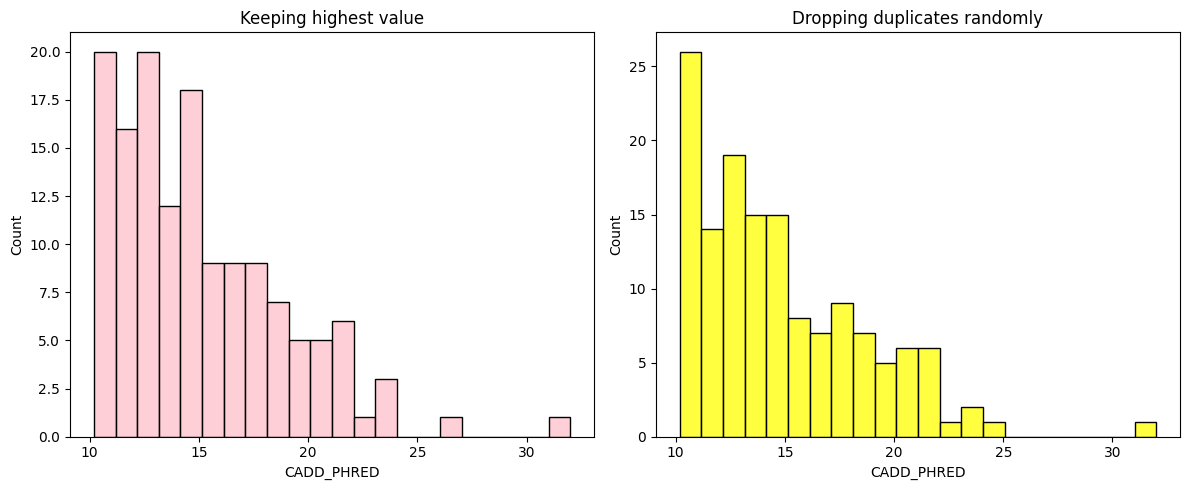

In [34]:
## examining CADD scores for each unique SNV (because VEP sometimes returned multiple variants for a single rsID)

temp_cadd_graph = cadd_filtered.drop_duplicates("#Uploaded_variation")
cadd_unique = cadd_filtered.loc[cadd_filtered.groupby("#Uploaded_variation")["CADD_PHRED"].idxmax()]


print(f"SNPs' variants that have CADD score that is 10 or greater (unique): {temp_cadd_graph.shape[0]}/{cadd_filtered.shape[0]}")
print(f"SNPs' variants that have CADD score that is 20 or greater (unique): {cadd_unique[cadd_unique.CADD_PHRED >= 20].shape[0]}/{cadd_filtered[cadd_filtered.CADD_PHRED >= 20].shape[0]}")

# temp_cadd_graph[temp_cadd_graph["CADD_PHRED"] >=20]

# print(cadd_unique.shape, temp_cadd_graph.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

sns.histplot(cadd_unique['CADD_PHRED'], color="pink", binwidth=1, ax=axes[0])
axes[0].set_title("Keeping highest value")

sns.histplot(temp_cadd_graph['CADD_PHRED'], color="yellow", binwidth=1, ax=axes[1])
axes[1].set_title("Dropping duplicates randomly")
plt.tight_layout()
plt.show()

# cadd_filtered[cadd_filtered.CADD_PHRED > 30]
# snp_in_regions[snp_in_regions["STRONGEST SNP-RISK ALLELE"] == "rs41267397-T"]

In [48]:
processed_micropeptides = pd.read_csv("./media2.txt", sep = '\t')

processed_micropeptides = processed_micropeptides.dropna(subset=["chrm"])
processed_micropeptides = processed_micropeptides[["Ribo-Seq_ORF", "rank", "manual evaluation rank", "notes"]]
processed_micropeptides = processed_micropeptides.add_prefix("p2_")
processed_micropeptides.rename(columns={"p2_Ribo-Seq_ORF":"orf_name"}, inplace=True)

print("Before merging with with Phase II data:", snp_in_regions.shape[0])
snp_in_regions_evo = pd.merge(snp_in_regions, processed_micropeptides, how="left", on = "orf_name")
print("fFter merging with with Phase II data:", snp_in_regions_evo.shape[0])

cadd_raw = pd.read_csv("/Users/nataliababalyk/Documents/thesis/CADD_scores.txt", sep = '\t')
# cadd_raw.isna().sum()
# cadd_raw = cadd_raw.dropna(subset=["CADD_PHRED"])
# cadd_raw.shape

cadd_raw_unique = cadd_raw.loc[cadd_raw.groupby("#Uploaded_variation")["CADD_PHRED"].idxmax()]
cadd_raw_unique.columns
cadd_raw_unique = cadd_raw_unique[["SYMBOL", "Location", "#Uploaded_variation", "Consequence", "Allele",
                                  'REF_ALLELE',"CADD_PHRED", "CADD_RAW", "CLIN_SIG"]]
cadd_raw_unique  = cadd_raw_unique.add_prefix("cadd_")
# cadd_raw_unique.head()
cadd_raw_unique = cadd_raw_unique.rename(columns = {"cadd_#Uploaded_variation": "SNP_RS"})

snp_in_regions_evo = pd.merge(snp_in_regions_evo, cadd_raw_unique, how = "left", on="SNP_RS")
print("After merging with with CADD scores data:", snp_in_regions_evo.shape[0])

snp_in_regions_evo.head()

## some new rows were created since media2 (from Phase II of the studied annonation project) may contain several rows a single ORF

Before merging with with Phase II data: 2838
fFter merging with with Phase II data: 2896
After merging with with CADD scores data: 2896


,CHR_ID,CHR_POS,REGION,STRONGEST SNP-RISK ALLELE,P-VALUE,PVALUE_MLOG,DISEASE/TRAIT,MAPPED_GENE,PUBMEDID,CONTEXT,INTERGENIC,RISK ALLELE FREQUENCY,OR or BETA,95% CI (TEXT),MAPPED_TRAIT,CHROM,starts,ends,orf_name,old_starts,old_ends,orf_biotype,gene_biotype,orf_sequence,orf_length,gene_length,length_check,gene_name,Riboseq_evidence,chrom_id,SNP_RS,num_starts,p2_rank,p2_manual evaluation rank,p2_notes,cadd_SYMBOL,cadd_Location,cadd_Consequence,cadd_Allele,cadd_REF_ALLELE,cadd_CADD_PHRED,cadd_CADD_RAW,cadd_CLIN_SIG
0,1,31927977,1p35.2,rs10914505-?,5.000000e-40,39.301030,Height,PTP4A2,30595370,intron_variant,0.0,NR,NaN,NaN,NaN,1_31927977,31919563,31938010,c1riboseqorf55,31919563;31937987,31919658;31938010,uORF,protein_coding,MPSPQLASVFRWNIRCTFMAILSVRADFCQAQHSIFADK*,120,18448,0.006505,PTP4A2,5,1_31919563,rs10914505,2,NaN,NaN,NaN,PTP4A2,1:31927977-31927977,intron_variant,T,G,8.451,0.817452,-
1,1,63809749,1p31.3,rs11208297-?,2.000000e-10,9.698970,Normal facial asymmetry (angle of surface orie...,ROR1,30631343,intron_variant,0.0,NR,NaN,NaN,facial asymmetry measurement,1_63809749,63774363,64009329,c1riboseqorf109,63774363;64009305,63774508;64009329,uoORF,protein_coding,MFCARPGSRRRRRLSERRNAPAAPPRDAPAAPGAAGRAAAGRTRGC...,171,234967,0.000728,ROR1,2,1_63774363,rs11208297,2,NaN,NaN,NaN,ROR1,1:63809749-63809749,intron_variant,C,T,1.313,0.053246,-
2,1,23098646,1p36.12,rs11578046-?,3.000000e-29,28.522879,Height,LUZP1,30595370,intron_variant,0.0,NR,NaN,NaN,NaN,1_23098646,23094264,23109024,c1riboseqorf37,23094264;23109022,23094380;23109024,uORF,protein_coding,MIDDGLQLSKKIVVAKRKVTISHPLEWNWMPLGAHIGWQ*,120,14761,0.008130,LUZP1,2,1_23094264,rs11578046,2,NaN,NaN,NaN,LUZP1,1:23098646-23098646,intron_variant,A,G,5.148,0.469768,-
3,1,52166955,1p32.3,rs17401875-?,3.000000e-17,16.522879,Height,ZFYVE9,30595370,intron_variant,0.0,NR,NaN,NaN,NaN,1_52166955,52142220,52216388,c1riboseqorf99,52142220;52216369,52142403;52216388,uORF,protein_coding,MRLGGCRALAAVAAAAAATAAPTGVGGFAAAPGAAPVPSGGGFRLR...,204,74169,0.002750,ZFYVE9,2,1_52142220,rs17401875,2,NaN,NaN,NaN,ZFYVE9,1:52166955-52166955,intron_variant,G,A,0.259,-0.359793,-
4,1,52166955,1p32.3,rs17401875-?,3.000000e-17,16.522879,Height,ZFYVE9,30595370,intron_variant,0.0,NR,NaN,NaN,NaN,1_52166955,52142374,52216464,c1riboseqorf100,52142374;52216369,52142403;52216464,uORF,protein_coding,MLKRRRPLLEDQTEHTESAGLAGGAADIMSKHREVCSLSRV*,126,74091,0.001701,ZFYVE9,4,1_52142374,rs17401875,2,NaN,NaN,NaN,ZFYVE9,1:52166955-52166955,intron_variant,G,A,0.259,-0.359793,-


In [68]:
## prioritization of the SNVs

snp_in_regions_evo = snp_in_regions_evo.loc[snp_in_regions_evo["cadd_CADD_PHRED"] != "-"]
# snp_in_regions_evo.shape
# snp_in_regions_evo.to_csv("/Users/nataliababalyk/Documents/thesis/temp_final_2.csv", index=False)

deleterious_snps = snp_in_regions_evo.copy()

print("Before variant prioritization:", deleterious_snps.shape[0])

deleterious_snps["cadd_CADD_PHRED"] = deleterious_snps["cadd_CADD_PHRED"].astype(float)
deleterious_snps = deleterious_snps[deleterious_snps["cadd_CADD_PHRED"] >= 12]
deleterious_snps = deleterious_snps[deleterious_snps["length_check"] == 1]
# print(deleterious_snps[["SNP_RS", "CADD_PHRED", "Consequence"]])
deleterious_snps = deleterious_snps[deleterious_snps["cadd_Consequence"] != "missense_variant"]
deleterious_snps["CHR_POS"] = deleterious_snps["CHROM"].str.split("_").str[1].astype(float).astype(int)
deleterious_snps = deleterious_snps.sort_values(by=['CHR_ID', 'CHR_POS'])
# deleterious_snps.shape
# deleterious_snps.head()

print("After variant prioritization:", deleterious_snps.shape[0])


idx = deleterious_snps.groupby("SNP_RS")["P-VALUE"].idxmin()
unique_deleterios = deleterious_snps.loc[idx].reset_index(drop=True)
# unique_deleterios["CHR_ID"] = unique_deleterios["CHR_ID"].astype(int)
unique_deleterios = unique_deleterios.sort_values(by=["CHR_ID", "CHR_POS"])

print("Keeping only unique SNVs:", unique_deleterios.shape[0])
deleterious_snps = deleterious_snps.sort_values(by=["CHR_ID", "CHR_POS"])
unique_deleterios.to_csv("../amino_acid_substitution/strong_candidates_14.txt", sep='\t', index=False)
# deleterious_snps.to_csv("/Users/nataliababalyk/Documents/thesis/remainings_to_analyse_29.txt", sep='\t' index=False)
# deleterious_snps
# unique_deleterios


Before variant prioritization: 2859
After variant prioritization: 29
Keeping only unique SNVs: 14
